In [16]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')
df.drop(["Unnamed: 0","team_id"], axis=1, inplace=True)
df.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,...,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,...,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,...,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,...,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,...,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,...,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [17]:
df.isnull().sum()

match_event_id            1563
location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
team_name                 1535
date_of_game              1550
home/away                 1497
shot_id_number            1563
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
match_id                     0
team_id                      0
remaining_min.1           1535
power_of_shot.1           1539
knockout_match.1          1493
remaining_sec.1           1539
distance_of_shot.1        1568
dtype: int64

In [18]:
for i in train_df.columns:
    print(df[i].nunique(), " ", i)

618   match_event_id
488   location_x
450   location_y
12   remaining_min
7   power_of_shot
2   knockout_match
20   game_season
60   remaining_sec
73   distance_of_shot
2   is_goal
6   area_of_shot
7   shot_basics
5   range_of_shot
1   team_name
1558   date_of_game
74   home/away
29134   shot_id_number
38   lat/lng
57   type_of_shot
6   type_of_combined_shot
1559   match_id
1   team_id
291   remaining_min.1
206   power_of_shot.1
382   knockout_match.1
354   remaining_sec.1
271   distance_of_shot.1


In [19]:
train_df = df[df["is_goal"].notnull()].copy()
test_df = df[df["is_goal"].isnull()].copy()
print(train_df.shape, " ", test_df.shape)

(24429, 27)   (6268, 27)


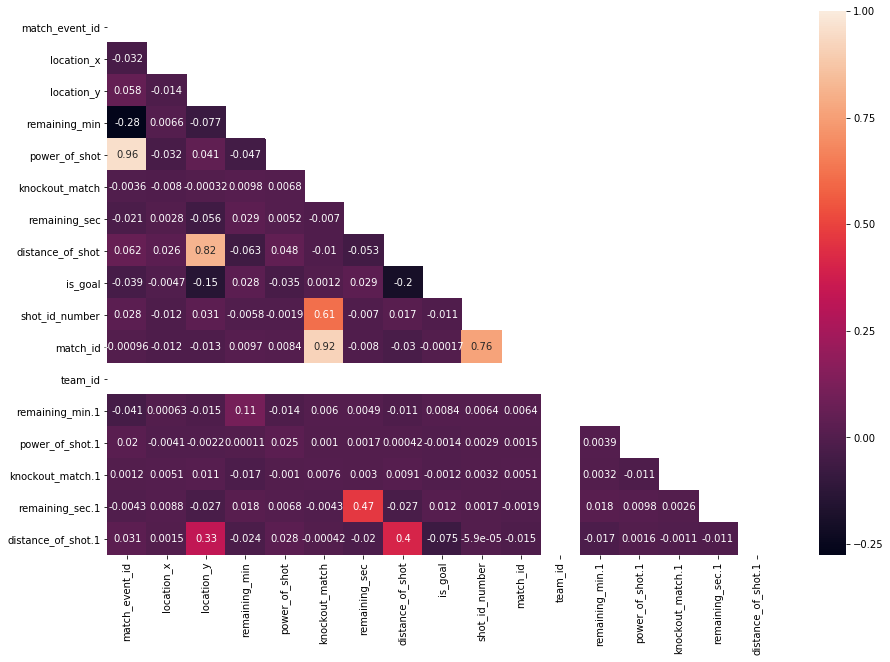

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,10))
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_df.corr(),annot=True, mask=mask)

In [ ]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']
param = {
    'bagging_freq': 5,          'bagging_fraction': 0.335,   'boost_from_average':'false',   'boost': 'gbdt',
    'feature_fraction': 0.041,   'learning_rate': 0.0083,     'max_depth': -1,                'metric':'auc',
    'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
    'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}
folds = StratifiedKFold(n_splits=20, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission.csv", index=False)

In [ ]:
sub = pd.DataFrame({"series_id": test['series_id'].values})
sub["surface"] = predictions[0]
for i in range(1,6):
    sub['surface'] = sub["surface"]+predictions[i]
sub['surface'] = sub["surface"]/6
sub2 = pd.DataFrame({"series_id": test_df['series_id'].values})
sub2["surface"] = predictions[2]
sub.head()
sub2.to_csv('submission39.csv', index=False)